# Load Ardupilot .bin log files

## with train passing by

These logs contains 2 chuncks of data.

- PARM: list of parameters that can be set and their values
- then there's messages, that is the values of what is actually logged (ex: battery voltage, GPS, IMU...)

https://ardupilot.org/copter/docs/logmessages.html#logmessages

Info on getting time, date from GPS time (GWk and GMS)
- https://stackoverflow.com/questions/33415475/how-to-get-current-date-and-time-from-gps-unsegment-time-in-python
- https://ardupilot.org/copter/docs/logmessages.html#gps
- https://en.racelogic.support/LabSat_GNSS_Simulators/LabSat_General_Knowledgebase/LabSat_Leap_Second_Guide
- https://discuss.ardupilot.org/t/converting-log-file-gms-gwk-to-correct-utc/69576


## Inspected logged messages

XKY0: EKF Yaw Estimator States
https://ardupilot.org/copter/docs/logmessages.html#xky0

## TO DO

Trigger with hysteresis

In [1]:
%matplotlib inline

In [2]:
from ardupilot_log_reader.reader import Ardupilot
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# import utm
# import math

from numpy.random import RandomState

# for date time management

import matplotlib.dates as mdates
import datetime as dt

In [3]:
HOME = os.getenv("HOME")
PATH2FILES = f'.'
PATH2FILES = f'{HOME}/Data/Drones/Flight_Logs/TrainBridge'
# PATH2FILES = f'{HOME}/pCloudDrive/ITRI/Drones_UAV/FlightLogs/'
# LOGNAME = '2024-07-18 15-26-17.bin' # dynamic flight
LOGNAME = 'x4_krtc_mag_interference.BIN'
FULLNAME = f'{PATH2FILES}/{LOGNAME}'

In [4]:

# parser = Ardupilot.parse(FULLNAME,types=['XKF1','XKF2','GPS','VISP', 'VISV', 'NOT_A_MESSAGE']) # adding a type not present in the log don't raise an error
parser = Ardupilot.parse(FULLNAME,types=['XKF1','XKF2','GPS','VISP','MAG','IMU','XKY0'])


In [7]:
mydf = parser.dfs['PARM']
print(mydf[mydf['Name'].str.contains('KF')])

        timestamp    TimeUS           Name  Value
71   1.719383e+09  73550028  FS_EKF_ACTION    1.0
72   1.719383e+09  73550034  FS_EKF_THRESH    0.8
396  1.719383e+09  73554708  AHRS_EKF_TYPE    3.0


In [17]:
print(mydf[mydf['Name'].str.contains('IMU')])

        timestamp    TimeUS          Name  Value
600  1.719383e+09  73557508  EK3_IMU_MASK    7.0


In [51]:
parser.dfs['GPS'][0:1]

,timestamp,TimeUS,I,Status,GMS,GWk,NSats,HDop,Lat,Lng,Alt,Spd,GCrs,VZ,Yaw,U
0,1.719383e+09,73613063,0,6,281732499,2320,32,0.72,22.743007,120.317457,19.09,0.022672,41.423664,0.015,0.0,1


In [8]:
mydf_gps = parser.dfs['GPS']
# mydf_visp = parser.dfs['VISP'] # no VISP this time
mydf_mag = parser.dfs['MAG']
mydf_imu = parser.dfs['IMU']
mydf_xkf1 = parser.dfs['XKF1']
mydf_xkf2 = parser.dfs['XKF2']
mydf_xky0 = parser.dfs['XKY0']

### GPS log analysis

In [16]:
# print(mydf_gps[-2:-1])
print(mydf_gps[:2])
print(mydf_gps[-2:])

      timestamp    TimeUS  I  Status        GMS   GWk  NSats  HDop        Lat  \
0  1.719383e+09  73613063  0       6  281732499  2320     32  0.72  22.743007   
1  1.719383e+09  73713095  0       6  281732599  2320     32  0.72  22.743007   

          Lng    Alt       Spd        GCrs     VZ  Yaw  U  
0  120.317457  19.09  0.022672   41.423664  0.015  0.0  1  
1  120.317457  19.09  0.003162  108.434944  0.042  0.0  1  
        timestamp     TimeUS  I  Status        GMS   GWk  NSats  HDop  \
854  1.719383e+09  184115892  0       5  281842999  2320     29  0.85   
855  1.719383e+09  184215876  0       5  281843099  2320     29  0.85   

           Lat         Lng    Alt       Spd        GCrs     VZ  Yaw  U  
854  22.743072  120.317768  18.64  0.030265    7.594643 -0.011  0.0  1  
855  22.743072  120.317768  18.64  0.048847  337.109436  0.096  0.0  1  


#### Get local time from GPS time

Install the following if needed.

The ardupilot log provides GMS and GWk, corresponding to the number of milliseconds since the start of GPS week started and the number of weeks seince 5 jan 1980, respectively.

See: https://ardupilot.org/copter/docs/logmessages.html#gps


In [13]:
# !pip uninstall -y leapseconds
# !pip install astropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 22.2 MB/s eta 0:00:00m eta 0:00:0136m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.0 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 5.1 MB/s eta 0:00:000m eta 0:00:01


In [9]:
from astropy.time import Time

In [10]:
def gps2utc(gpsweek, gpsmilliseconds):
    """ GPS time to UTC + 8.

    Parameters
    ----------
    gpsweek : int
        GPS week number, i.e. 1866.
    gpsseconds : int
        Number of milli seconds since the beginning of week (GMS).
    gpsseconds : int
        Number of seconds since the beginning of week.

    Returns
    -------
    datetime
        datetime instance with UTC time.
    """
    gpsseconds = gpsmilliseconds / 1000
    second_in_8hrs = 8*3600
    gpsseconds = gpsseconds + second_in_8hrs
    print(f'GPS week: {gpsweek}, GPS seconds: {gpsseconds}')
    secs_in_week = 604800
    secs = gpsweek * secs_in_week + gpsseconds

    
    t_gps = Time(secs, format="gps")
    t_utc = Time(t_gps, format="iso", scale="utc")

    return t_utc.datetime

In [11]:
# start and end time of log
logtstart = gps2utc(mydf_gps['GWk'][1],mydf_gps['GMS'][1])
logtend = gps2utc(mydf_gps['GWk'][len(mydf_gps)-1],mydf_gps['GMS'][len(mydf_gps)-1])
print(f'log started on {logtstart}, ended on {logtend}')

GPS week: 2320, GPS seconds: 310532.599
GPS week: 2320, GPS seconds: 310643.099
log started on 2024-06-26 14:15:14.599000, ended on 2024-06-26 14:17:05.099000


In [12]:
# get the date and time for all the points
datetime_gps = gps2utc(mydf_gps['GWk'][1:-1],mydf_gps['GMS'][1:-1])
print(datetime_gps[0])

GPS week: 1      2320
2      2320
3      2320
4      2320
5      2320
       ... 
850    2320
851    2320
852    2320
853    2320
854    2320
Name: GWk, Length: 854, dtype: int64, GPS seconds: 1      310532.599
2      310532.699
3      310532.799
4      310532.899
5      310533.099
          ...    
850    310642.499
851    310642.599
852    310642.799
853    310642.899
854    310642.999
Name: GMS, Length: 854, dtype: float64
2024-06-26 14:15:14.599000


In [58]:
ttime = gps2utc(2151,150825)
print(ttime)
print(ttime.hour)
print(ttime.minute)

GPS week: 2151, GPS seconds: 150.825
2021-03-28 00:02:12.825000


In [36]:
# doing it manually
mytime = mydf_gps['GMS'][10] #1092121243.0
# mytime = 457012000
print(f'GPS timestamp = {mytime}')
t = Time(mytime, format='gps')
# t = Time(t, format='iso') # same as scale='tai'
t = Time(t, format='iso', scale='utc') # 
print(t)

GPS timestamp = 457014000
1994-06-30 12:19:51.000


In [12]:
# Yaw from GPS: only with GPS with 2 antennas
# print(mydf_gps['Yaw']) 

In [17]:
print(mydf_gps['NSats'])

0       18
1       18
2       18
3       18
4       18
        ..
2674    16
2675    15
2676    15
2677    15
2678    15
Name: NSats, Length: 2679, dtype: int64


In [14]:
nsats = mydf_gps['NSats'].to_numpy()
gps_speed = mydf_gps['Spd'].to_numpy()
gps_vz = mydf_gps['VZ'].to_numpy()
gps_hdop = mydf_gps['HDop'].to_numpy()
gps_ts = mydf_gps['timestamp'].to_numpy()
gps_tus = mydf_gps['TimeUS'].to_numpy()

In [17]:
len(nsats), len(magx)

NameError: name 'magx' is not defined

In [19]:
gps_tus_avg = np.mean(gps_tus[:100])/1e6
print(f'average samp time (from GPS) in us: {gps_tus_avg}')
gps_t = np.arange(len(gps_ts))*gps_tus_avg

average samp time (from GPS) in us: 23.84375289


In [77]:
# zoomrange = np.arange(1500,2000)
zoomrange = np.arange(0,300)
zoomrange1 = np.arange(0,100)
zoomrange2 = np.arange(150,250)

NameError: name 'nsats' is not defined

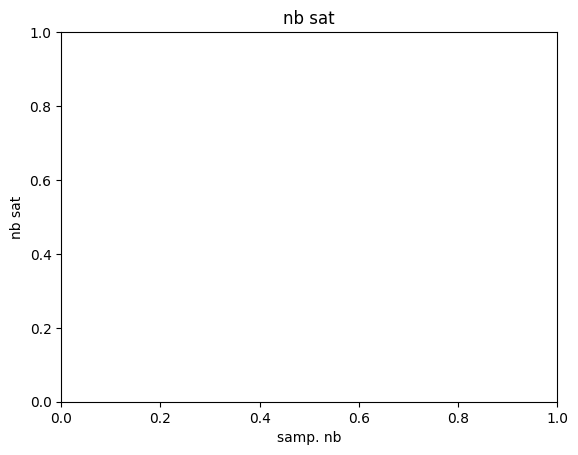

In [13]:
fig,ax = plt.subplots(1)
ax.set_title('nb sat')
ax.set_xlabel('samp. nb')
ax.set_ylabel('nb sat')
ax.plot(nsats)

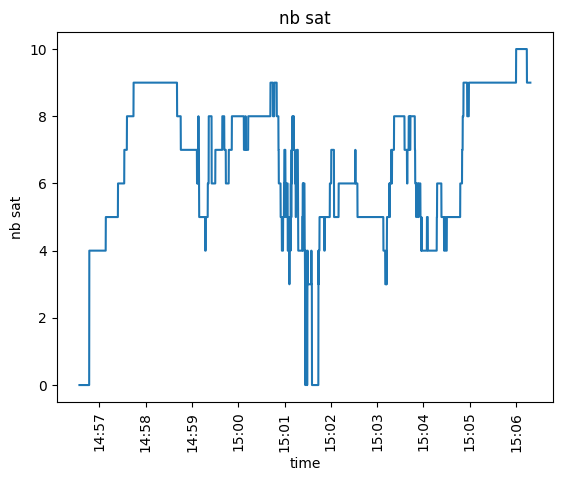

In [28]:
fig,ax = plt.subplots(1)
ax.set_title('nb sat')
ax.set_xlabel('time')
ax.set_ylabel('nb sat')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) #:%S'))

ax.tick_params(axis='x',rotation=90)

ax.plot(datetime_gps,nsats[1:-1])

#### get time and date from exif

use `identify` from imagemagick

    identify -format "%[EXIF:DateTime]\n" *.jpg

Edit with vi or write some code to get the following list.

In [29]:
dates_tick = []
dates_tick.append(dt.datetime.strptime("2024:07:19 14:59:08","%Y:%m:%d %H:%M:%S"))
dates_tick.append(dt.datetime.strptime("2024:07:19 14:59:32","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:00:18","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:00:58","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:01:33","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:01:49","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:02:17","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:02:36","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:04:04","%Y:%m:%d %H:%M:%S")) 
dates_tick.append(dt.datetime.strptime("2024:07:19 15:04:31","%Y:%m:%d %H:%M:%S")) 

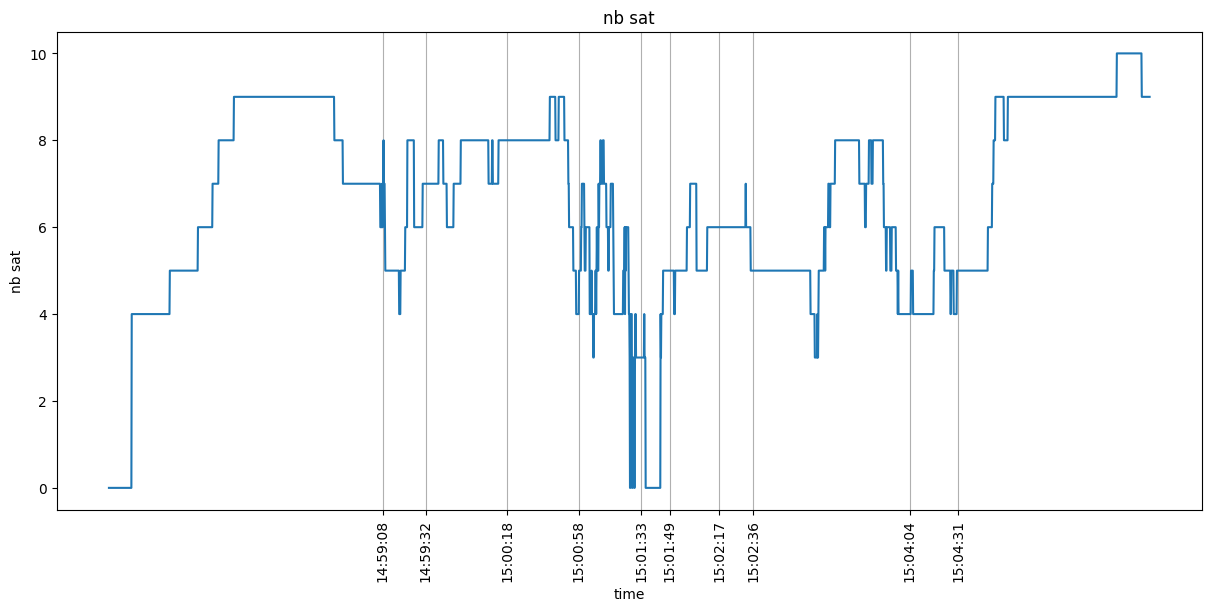

In [34]:
fig,ax = plt.subplots(1, figsize=(12, 6),layout='constrained')
ax.set_title('nb sat')
ax.set_xlabel('time')
ax.set_ylabel('nb sat')
ax.plot(datetime_gps,nsats[1:-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax.tick_params(axis='x',rotation=90)
# ax.set_xticks( [dates_tick[0],dates_tick[1],dates_tick[2],dates_tick[3]])
ax.set_xticks( dates_tick)
ax.grid(True,axis='x')
plt.savefig("gps_antenna_location_nbsats.svg", format='svg')

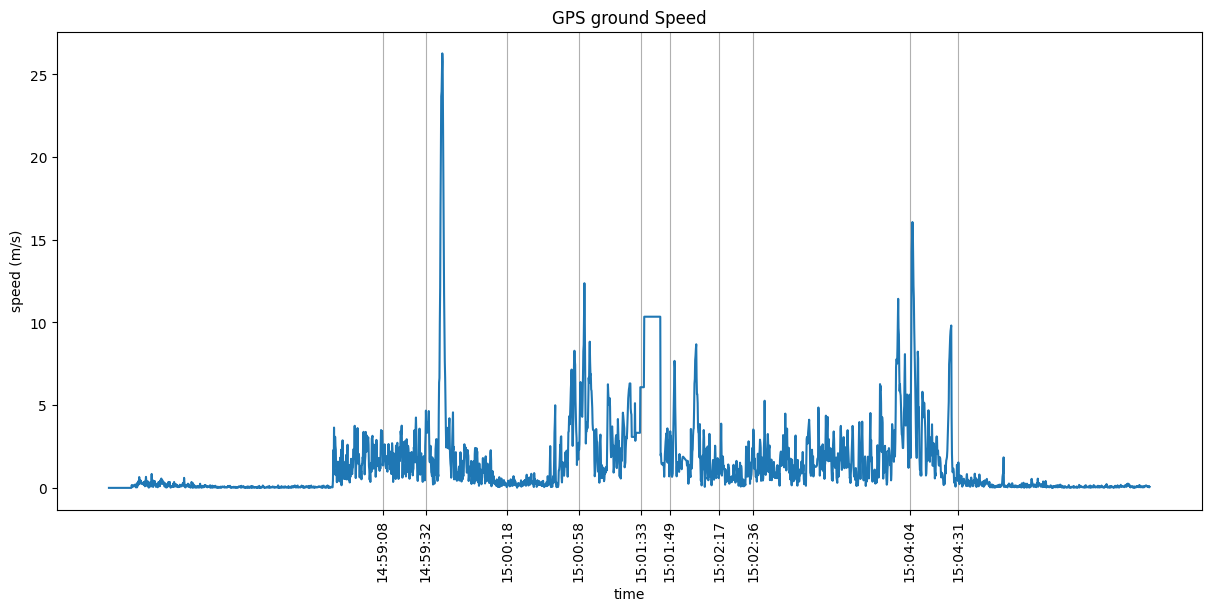

In [35]:
fig,ax = plt.subplots(1, figsize=(12, 6),layout='constrained')
ax.set_title('GPS ground Speed')
ax.set_xlabel('time')
ax.set_ylabel('speed (m/s)')
ax.plot(datetime_gps,gps_speed[1:-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax.tick_params(axis='x',rotation=90)
# ax.set_xticks( [dates_tick[0],dates_tick[1],dates_tick[2],dates_tick[3]])
ax.set_xticks( dates_tick)
ax.grid(True,axis='x')
plt.savefig("gps_antenna_location_gndspeed.svg", format='svg')

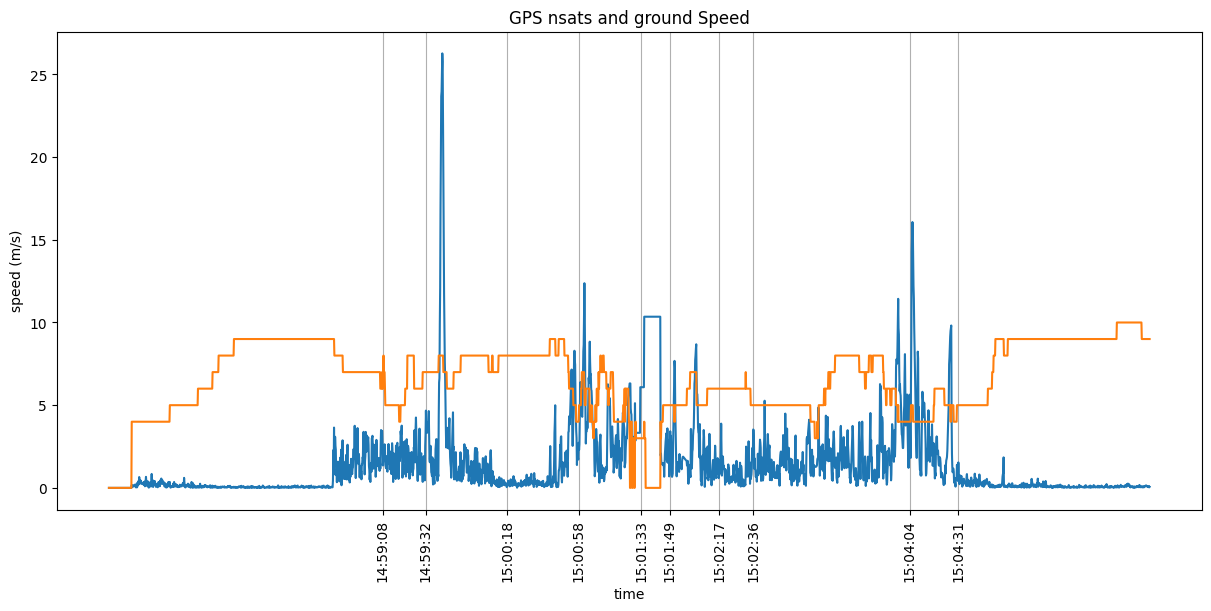

In [37]:
fig,ax = plt.subplots(1, figsize=(12, 6),layout='constrained')
ax.set_title('GPS nsats and ground Speed')
ax.set_xlabel('time')
ax.set_ylabel('speed (m/s)')
ax.plot(datetime_gps,gps_speed[1:-1])
ax.plot(datetime_gps,nsats[1:-1])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax.tick_params(axis='x',rotation=90)
# ax.set_xticks( [dates_tick[0],dates_tick[1],dates_tick[2],dates_tick[3]])
ax.set_xticks( dates_tick)
ax.grid(True,axis='x')
plt.savefig("gps_antenna_location_nsats_gndspeed.svg", format='svg')

In [26]:
hours = mdates.drange(logtstart,logtend,dt.timedelta(minutes=1))
print(hours)

[19923.62261806 19923.6233125  19923.62400694 19923.62470139
 19923.62539583 19923.62609028 19923.62678472 19923.62747917
 19923.62817361 19923.62886806]


In [ ]:
fig,ax = plt.subplots(1)
ax.set_title('nb sat')
ax.set_xlabel('time')
ax.set_ylabel('nb sat')

# pouet
# ax.plot(hours,nsats)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(hours,nsats)
# plt.plot(nsats)
plt.gcf().autofmt_xdate()
plt.show()

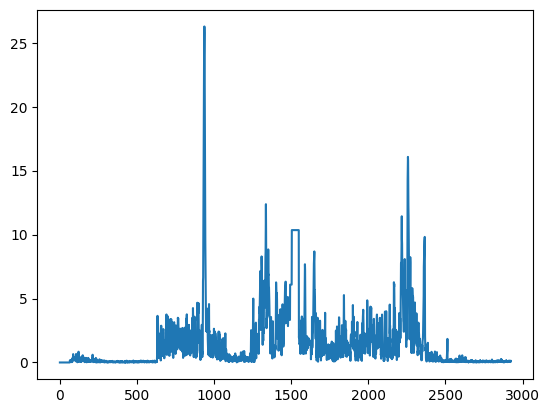

In [16]:
fig,ax = plt.subplots(1)
ax.plot(gps_speed)

(0.0, 0.5)

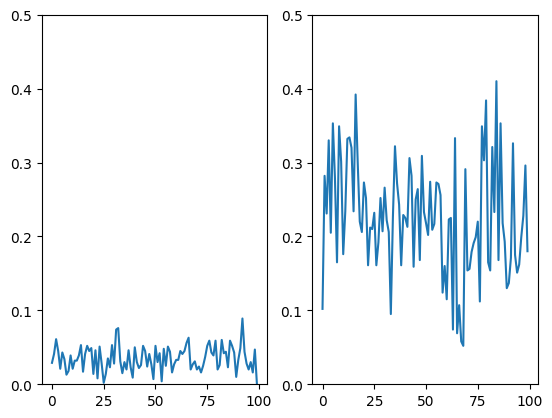

In [26]:
fig,ax = plt.subplots(1,2)
# ax[0].plot(gps_speed[1450:1550])
# ax[1].plot(gps_speed[1780:1900])
ax[0].plot(gps_speed[zoomrange1])
ax[1].plot(gps_speed[zoomrange2])
ax[0].set_ylim([0,0.5])
ax[1].set_ylim([0,0.5])

(-0.2, 1.3)

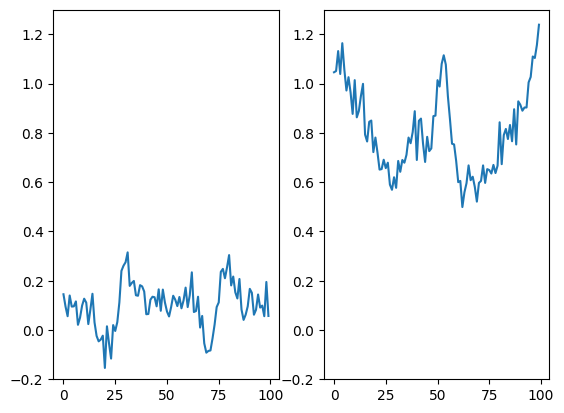

In [35]:
fig,ax = plt.subplots(1,2)
# ax[0].plot(gps_speed[1450:1550])
# ax[1].plot(gps_speed[1780:1900])
ax[0].plot(gps_vz[zoomrange1])
ax[1].plot(gps_vz[zoomrange2])
ax[0].set_ylim([-0.20,1.3])
ax[1].set_ylim([-0.20,1.3])

In [50]:
gps_speed_rms = np.sqrt(np.mean(gps_speed[zoomrange]**2))
print(gps_speed_rms)

0.04419898403123528


In [29]:
# ground speed
gps_speed_rms1 = np.sqrt(np.mean(gps_speed[zoomrange1]**2))
gps_speed_rms2 = np.sqrt(np.mean(gps_speed[zoomrange2]**2))
ratio = gps_speed_rms2 / gps_speed_rms1
print(gps_speed_rms1,gps_speed_rms2, ratio )

0.0389716579626014 0.23777885737552343 6.101327729082107


In [36]:
# vertical speed
gps_vz_rms1 = np.sqrt(np.mean(gps_vz[zoomrange1]**2))
gps_vz_rms2 = np.sqrt(np.mean(gps_vz[zoomrange2]**2))
ratio = gps_vz_rms2 / gps_vz_rms1
print(gps_vz_rms1,gps_vz_rms2, ratio )

0.13545811806319336 0.8232086551754252 6.077219047081293


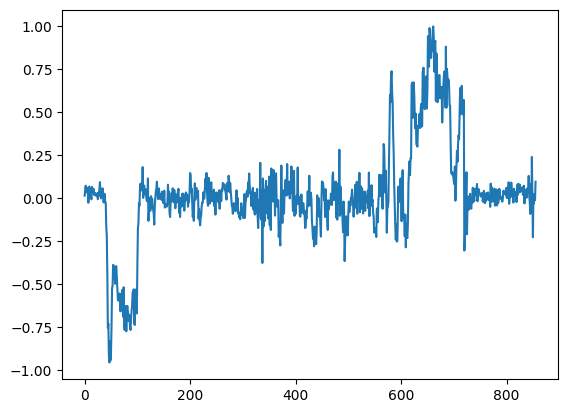

In [75]:
fig,ax = plt.subplots(1)
ax.plot(gps_vz)

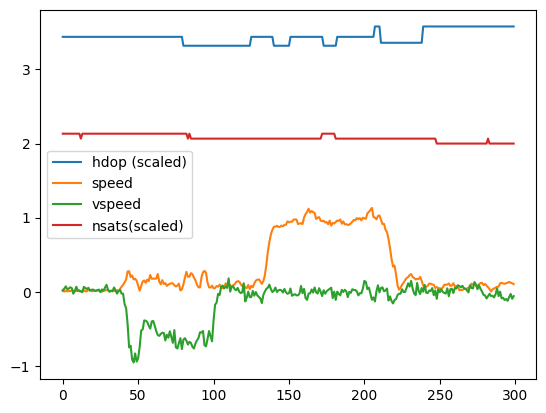

In [78]:
fig,ax = plt.subplots(1)
ax.plot(2*gps_hdop[zoomrange]+2,label = 'hdop (scaled)')
ax.plot(gps_speed[zoomrange],label = 'speed')
ax.plot(gps_vz[zoomrange],label = 'vspeed')
ax.plot(nsats[zoomrange]/15,label = 'nsats(scaled)')
ax.legend()

In [20]:
type(mydf_gps['NSats'])

pandas.core.series.Series

In [29]:
# not present in this log
# px,py,pz = mydf_visp['PX'], mydf_visp['PY'], mydf_visp['PZ']
# fig,ax = plt.subplots(1)
# ax.plot(px,py)
# plt.show()

### XKF1 log analysis

In [53]:
xkf1_yaw = mydf_xkf1['Yaw']
print(xkf1_yaw[:10])
print(xkf1_yaw[-10:])

0    182.68
1    182.62
2    182.80
3    182.68
4    182.62
5    182.80
6    182.67
7    182.61
8    182.80
9    182.67
Name: Yaw, dtype: float64
3311    214.31
3312    189.27
3313    212.04
3314    214.25
3315    189.13
3316    211.91
3317    214.12
3318    189.15
3319    211.93
3320    214.14
Name: Yaw, dtype: float64


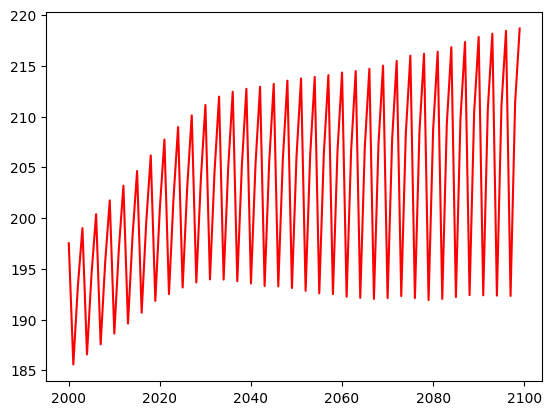

In [54]:
fig,ax = plt.subplots(1)
# ax.plot(xkf1_yaw,'r')
ax.plot(xkf1_yaw[2000:2100],'r')
# ax.plot(magy,'g')
# ax.plot(magz[:100],'b')
plt.show()

### Magnetometer log analysis

In [54]:
magx,magy,magz = mydf_mag['MagX'].to_numpy(), mydf_mag['MagY'].to_numpy(), mydf_mag['MagZ'].to_numpy()
# seems that magx contains data from 2 magnetometer, 
# we take one every other elements
# magx1,magy1,magz1 = magx[0::2],magy[0::2],magz[0::2]
magx1,magy1,magz1 = magx[0::2].copy(),magy[0::2].copy(),magz[0::2].copy()
magx2,magy2,magz2 = magx[1::2],magy[1::2],magz[1::2] 
magm1 = np.sqrt(magx1*magx1+magy1*magy1+magz1*magz1)
# magx2 = magx[1::2],magy2 = magy[1::2],magz2 = magz[1::2]
mag_health = mydf_mag['Health']
mag1_health = mag_health[0::2]
mag2_health = mag_health[1::2]

In [55]:
magx1,magm1

(array([-269, -270, -268, ..., -247, -247, -247]),
 array([311.93268505, 314.28331168, 313.35921879, ..., 345.02608597,
        345.94508235, 346.09102849]))

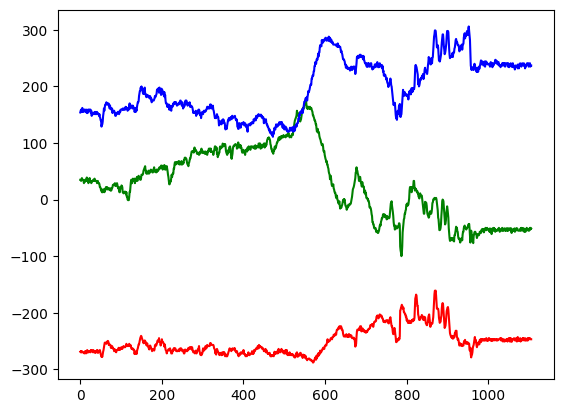

In [56]:
fig,ax = plt.subplots(1)
ax.plot(magx1,'r')
# ax.plot(magx1[300:400],'r')
# ax.plot(-100*mag_health[1300:1400],'g')
ax.plot(magy1,'g')
ax.plot(magz1,'b')
plt.savefig("magx_from_log_with_train.png", format='png')
# plt.savefig("magx_from_log_with_train_zoomin.png", format='png')
plt.show()

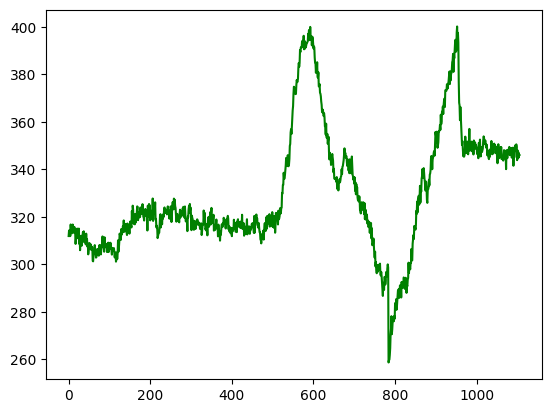

In [57]:
fig,ax = plt.subplots(1)
ax.plot(magm1,'g')
# ax.plot(magx[:100],'r')
# ax.plot(magy,'g')
# ax.plot(magz[:100],'b')
plt.show()

# 4th difference

https://cdnsciencepub.com/doi/full/10.1139/juvs-2018-0006

4thdiff= (T_-2 -4*T_-1 + 6*T_0 - 4*T_1 +T_2)/16

In [100]:
strd = 3 # stride
fdiff=(magm1[0:-strd*4-1] -4*magm1[strd:-strd*3-1]
       +6*magm1[2*strd:-strd*2-1]-4*magm1[3*strd:-strd*1-1]+magm1[4*strd:-1])/16

In [133]:
strd = 2 # stride
c1,c2,c3,c4,c5=2,-8,16,-8,2
smabs = np.abs(c1)+np.abs(c2)+np.abs(c3)+np.abs(c4)+np.abs(c5)
fdiff=(c1*magm1[0:-strd*4-1] +c2*magm1[strd:-strd*3-1]
       +c3*magm1[2*strd:-strd*2-1]+c4*magm1[3*strd:-strd*1-1]+c5*magm1[4*strd:-1])/smabs # (c1+c2+c3+c4+c5)

In [134]:
# fdiff=(magm1[0:-5] -4*magm1[1:-4]+6*magm1[2:-3]-4*magm1[3:-2]+magm1[4:-1])/16

In [135]:
# fdiff=(magm1[0:-9] -4*magm1[2:-7]+6*magm1[4:-5]-4*magm1[6:-3]+magm1[8:-1])/16

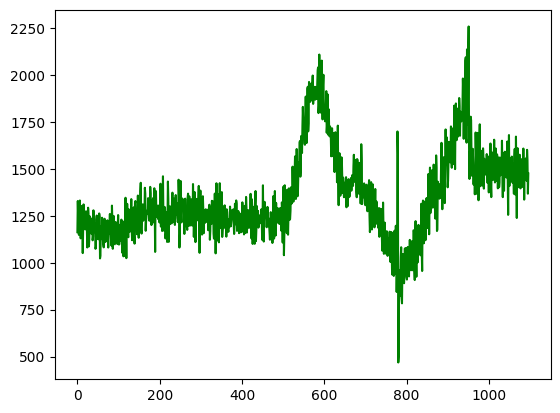

In [136]:
fig,ax = plt.subplots(1)
ax.plot(fdiff*fdiff,'g')

plt.show()

In [59]:
magx1.shape,magm1.shape,magm1[0:5],magm1[1:6] 

((1106,),
 (1106,),
 array([311.93268505, 314.28331168, 313.35921879, 313.28900396,
        311.91825852]),
 array([314.28331168, 313.35921879, 313.28900396, 311.91825852,
        316.81066901]))

In [60]:
magm1[0:5]+magm1[1:6] 

array([626.21599673, 627.64253047, 626.64822275, 625.20726248,
       628.72892754])

In [61]:
magm1[0:5] -4*magm1[1:6] +6*magm1[2:7]-4*magm1[3:8]+magm1[4:9]

array([ -6.28300624,   9.71809518, -22.24091799,  26.61297207,
       -15.67453288])

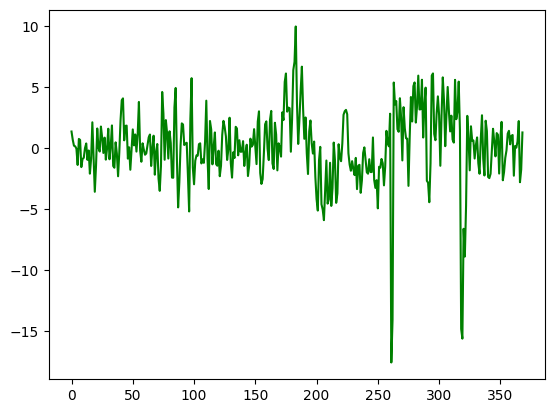

In [205]:
fig,ax = plt.subplots(1)
dx = 1
# ax.plot(fdiff,'g')
# ax.plot(np.gradient(np.gradient(magm1)),'g')
# ax.plot(np.gradient(magm1)*
        # np.gradient(magm1),'g')
ax.plot(np.gradient(magm1[::3],dx),'g')
# 
# ax.plot(magx[:100],'r')
# ax.plot(magy,'g')
# ax.plot(magz[:100],'b')
plt.show()

In [84]:
#https://stackoverflow.com/questions/40773275/sliding-standard-deviation-on-a-1d-numpy-array
W =20 # Window size
nrows = magm1.size - W + 1
n = magm1.strides[0]
a2D = np.lib.stride_tricks.as_strided(magm1,shape=(nrows,W),strides=(n,n))
out = np.std(a2D, axis=1)

In [169]:
np.arange(-W/2,W/2)

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

In [170]:
def rolling_variance_mod(a, W):
    b = np.empty(a.size-W+1)
    for i in range(b.size):
        b[i] = np.std(a[i:i+W]*np.arange(-W/2,W/2))
        # b[i] = np.std(a[i:i+W]*np.arange(W))
    return b

In [172]:
out = rolling_variance_mod(magm1,20)

In [182]:
# compute rolling stdev
# W : window side
# a input array
def rolling_variance(a, W):
    b = np.empty(a.size-W+1)
    for i in range(b.size):
        b[i] = np.std(a[i:i+W])
    return b

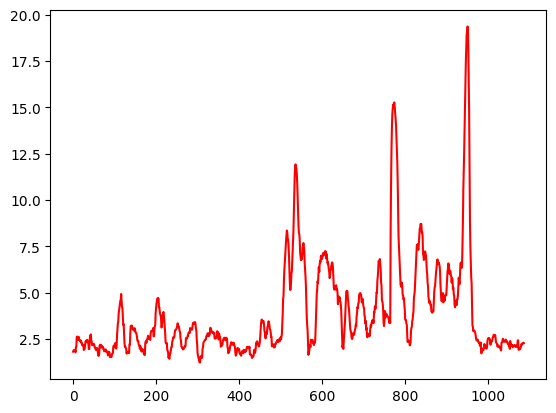

In [183]:
out = rolling_variance(magm1,20)
fig,ax = plt.subplots(1)
ax.plot(out,'r')
plt.show()

In [192]:
# o: offset (e.g. earth mag field at start)

def rolling_mean(a, W,o):
    b = np.empty(a.size-W+1)
    for i in range(b.size):
        b[i] = np.mean(a[i:i+W]-o)
    return b

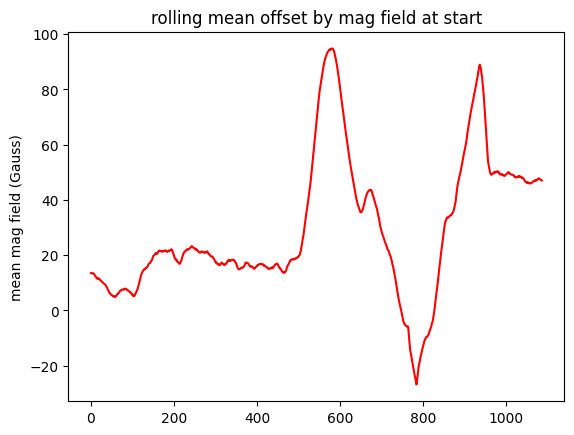

In [225]:
out = rolling_mean(magm1,20,300)
fig,ax = plt.subplots(1)
ax.plot(out,'r')
ax.set_ylabel('mean mag field (Gauss)')
ax.set_title('rolling mean offset by mag field at start')
plt.show()

In [242]:

# rolling mean of rolling mean
def rolling_rolling_mean(a, W1,W2):
    b = np.empty(a.size-W1-W2+1)
    for i in range(b.size):
        o = np.mean(a[i:i+W1])
        b[i] = np.mean(a[i+W2:i+W2+W1]-o)
    # return b
    return b*b

In [243]:
out = rolling_rolling_mean(magm1,20,20)

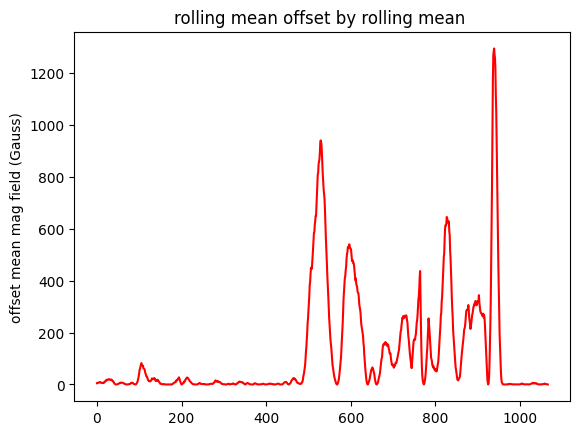

In [244]:
# it looks like acceleration and deceleration
fig,ax = plt.subplots(1)
ax.set_ylabel('offset mean mag field (Gauss)')
ax.set_title('rolling mean offset by rolling mean ')
ax.plot(out,'r')
plt.show()

In [272]:
# https://stackoverflow.com/questions/23289976/how-to-find-zero-crossings-with-hysteresis/23291658#23291658
def hyst(x, th_lo, th_hi, initial = False):
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    if not ind.size: # prevent index error if ind is empty
        return np.zeros_like(x, dtype=bool) | initial
    cnt = np.cumsum(lo_or_hi) # from 0 to len(ind)
    return np.where(cnt, hi[ind[cnt-1]], initial)
def hyst_hold(x, th_lo, th_hi, hold, initial = False):
    hi = x >= th_hi
    lo_or_hi = (x <= th_lo) | hi
    ind = np.nonzero(lo_or_hi)[0]
    if not ind.size: # prevent index error if ind is empty
        return np.zeros_like(x, dtype=bool) | initial
    cnt = np.cumsum(lo_or_hi) # from 0 to len(ind)
    print(f'lo_or_hi = {lo_or_hi}, len = {len(lo_or_hi)}')
    print(f'ind = {ind}, len = {len(ind)}')
    print(f'cnt = {cnt[-20:]}, len = {len(cnt)}')
    return np.where(cnt, hi[ind[cnt-1]], initial)

In [328]:
v_high = 200
v_low = 10
hold_t = 50 # hold for 20 samples
values = out
# find transitions from below v_low to above v_high    
transitions = np.zeros_like(values, dtype=bool)

state = 1

# for i in range(len(values)):
#     if values[i] > v_high:
#         # previous state was low, this is a low-to-high transition
#         transitions[i] = True
#         cur_hi_idx = i
#         # if state == 0:
#         #     transitions[i] = True
#         # state = 1
#     if values[i] < v_low:
#         state = 0
cur_hi_idx = 0
for i in range(len(values)):
    if values[i] > v_high:
        # previous state was low, this is a low-to-high transition
        transitions[i] = True
        state = 1
        cur_hi_idx = i
        # if state == 0:
        #     transitions[i] = True
        # state = 1
    else:
        if (i + hold_t) < len(values):
            i = i + hold_t -1
            print(i)
        else:
            i = len(values)
        state = 0
    
    if values[i] < v_low:
        if state == 1:
            # hold the high threshold for hold_t
            for j in range (hold_t):
                if (i+j) < len(values):
                    transitions[i+j] = True
            i = i+j 
            state = 0
            

49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311

IndexError: index 1067 is out of bounds for axis 0 with size 1067

[]

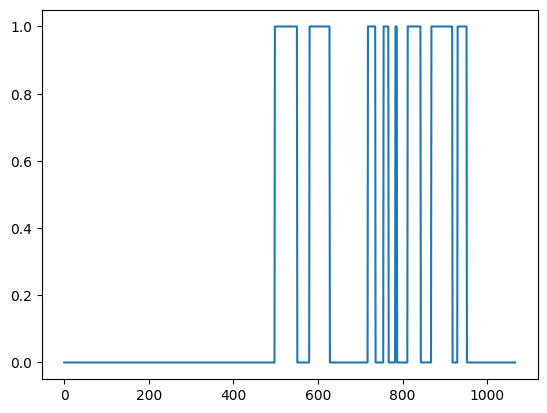

In [324]:
fig,ax=plt.subplots(1)
ax.plot(transitions)
plt.plot()

lo_or_hi = [False False False ...  True  True  True], len = 1067
ind = [  44   45   46   47   69   70   71   72   73   89   90   91   92  157
  161  162  163  164  165  166  167  168  169  170  171  172  173  175
  176  177  200  201  230  231  232  233  234  235  236  256  257  258
  259  260  261  262  263  264  265  303  304  305  306  307  314  315
  327  328  329  350  351  363  364  365  366  367  368  369  381  382
  383  396  397  398  399  400  401  402  416  419  420  421  422  433
  434  435  436  437  438  452  453  494  495  496  497  498  499  500
  501  502  503  504  505  506  507  508  509  510  511  512  513  514
  515  516  517  518  519  520  521  522  523  524  525  526  527  528
  529  530  531  532  533  534  535  536  537  538  539  540  541  542
  543  544  545  546  547  548  549  550  551  552  553  554  555  556
  567  568  577  578  579  580  581  582  583  584  585  586  587  588
  589  590  591  592  593  594  595  596  597  598  599  600  601  602
  603 

[]

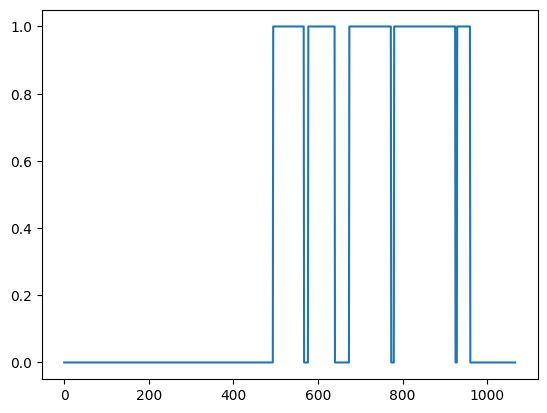

In [274]:
# hystout = hyst(out,0.5,200)
hystout = hyst_hold(out,0.5,100,10)
print(len(out))
fig,ax=plt.subplots(1)
ax.plot(hystout)
plt.plot()

[]

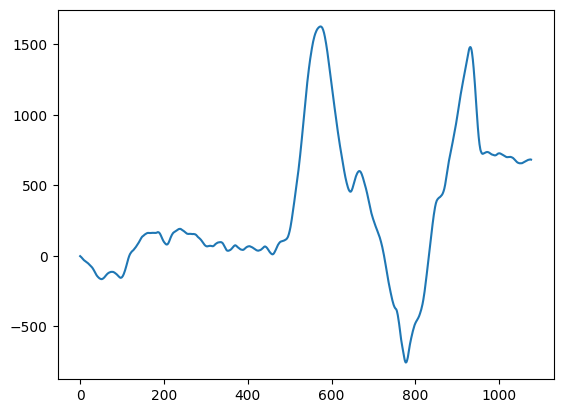

In [239]:
fig,ax=plt.subplots(1)
ax.plot(np.cumsum(out))
plt.plot()

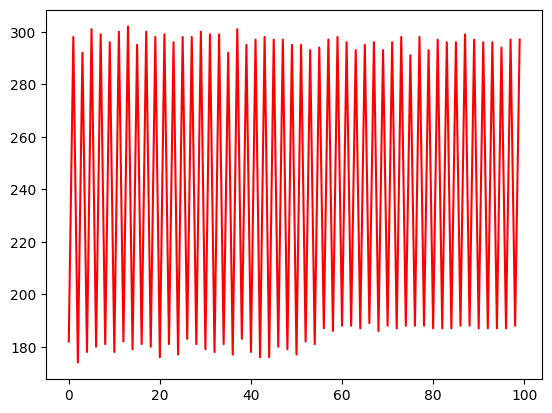

In [24]:
fig,ax = plt.subplots(1)
# ax.plot(magx,'r')
ax.plot(magx[:100],'r')
# ax.plot(magy,'g')
# ax.plot(magz[:100],'b')
plt.show()

## Exploring parameters

In [5]:
print(parser.dfs.keys())

dict_keys(['PARM', 'XKF1', 'XKF2', 'IMU', 'GPS', 'MAG', 'XKY0'])


In [6]:
print(parser.dfs)

{'PARM':          timestamp     TimeUS             Name         Value
0     1.719383e+09   73549319   FORMAT_VERSION     120.00000
1     1.719383e+09   73549325    SYSID_THISMAV       1.00000
2     1.719383e+09   73549331      SYSID_MYGCS     255.00000
3     1.719383e+09   73549337   PILOT_THR_FILT       0.00000
4     1.719383e+09   73549346  PILOT_TKOFF_ALT       0.00000
...            ...        ...              ...           ...
1012  1.719383e+09  123073881     STAT_FLTTIME   66123.00000
1013  1.719383e+09  123074251     STAT_RUNTIME  444944.00000
1014  1.719383e+09  154073912     STAT_FLTTIME   66154.00000
1015  1.719383e+09  154074281     STAT_RUNTIME  444975.00000
1016  1.719383e+09  174173952   MOT_THST_HOVER       0.44056

[1017 rows x 4 columns], 'XKF1':          timestamp     TimeUS  C  Roll  Pitch     Yaw        VN        VE  \
0     1.719383e+09   73577617  0  0.69  -0.40  182.68  0.003080  0.008778   
1     1.719383e+09   73577617  1  0.67  -0.46  182.62  0.003496 -0.0029

In [73]:
print(parser.dfs['PARM'])

         timestamp     TimeUS             Name         Value
0     1.719383e+09   73549319   FORMAT_VERSION     120.00000
1     1.719383e+09   73549325    SYSID_THISMAV       1.00000
2     1.719383e+09   73549331      SYSID_MYGCS     255.00000
3     1.719383e+09   73549337   PILOT_THR_FILT       0.00000
4     1.719383e+09   73549346  PILOT_TKOFF_ALT       0.00000
...            ...        ...              ...           ...
1012  1.719383e+09  123073881     STAT_FLTTIME   66123.00000
1013  1.719383e+09  123074251     STAT_RUNTIME  444944.00000
1014  1.719383e+09  154073912     STAT_FLTTIME   66154.00000
1015  1.719383e+09  154074281     STAT_RUNTIME  444975.00000
1016  1.719383e+09  174173952   MOT_THST_HOVER       0.44056

[1017 rows x 4 columns]


In [8]:
print(parser.dfs['PARM'][:20])

       timestamp    TimeUS              Name   Value  Default
0   1.721360e+09  62446981    FORMAT_VERSION   120.0    120.0
1   1.721360e+09  62447012     SYSID_THISMAV     1.0      1.0
2   1.721360e+09  62447019       SYSID_MYGCS   255.0    255.0
3   1.721360e+09  62447025    PILOT_THR_FILT     0.0      0.0
4   1.721360e+09  62447033   PILOT_TKOFF_ALT     0.0      0.0
5   1.721360e+09  62447040     PILOT_THR_BHV     0.0      0.0
6   1.721360e+09  62447048      SERIAL0_BAUD   115.0    115.0
7   1.721360e+09  62447068  SERIAL0_PROTOCOL     2.0      2.0
8   1.721360e+09  62447097  SERIAL1_PROTOCOL     2.0     33.0
9   1.721360e+09  62447106      SERIAL1_BAUD  1500.0     57.0
10  1.721360e+09  62447114  SERIAL2_PROTOCOL     2.0      2.0
11  1.721360e+09  62447150      SERIAL2_BAUD    57.0     57.0
12  1.721360e+09  62447158  SERIAL3_PROTOCOL    37.0     37.0
13  1.721360e+09  62447167      SERIAL3_BAUD   230.0    230.0
14  1.721360e+09  62447175  SERIAL4_PROTOCOL     5.0      5.0
15  1.72

In [9]:
print(parser.dfs['MAG'])

         timestamp     TimeUS  I  MagX  MagY  MagZ  OfsX  OfsY  OfsZ  MOX  \
0     1.721288e+09   69822408  0  -221  -221   302   -17    48    32    0   
1     1.721288e+09   69922300  0  -219  -220   305   -17    48    32    0   
2     1.721288e+09   70022264  0  -220  -221   305   -17    48    32    0   
3     1.721288e+09   70122269  0  -221  -221   304   -17    48    32    0   
4     1.721288e+09   70222300  0  -221  -220   304   -17    48    32    0   
...            ...        ... ..   ...   ...   ...   ...   ...   ...  ...   
5349  1.721288e+09  695822440  0  -181  -234   322   -17    48    32    0   
5350  1.721288e+09  695922243  0  -181  -234   323   -17    48    32    0   
5351  1.721288e+09  696022244  0  -180  -234   320   -17    48    32    0   
5352  1.721288e+09  696122256  0  -181  -233   320   -17    48    32    0   
5353  1.721288e+09  696222227  0  -181  -234   325   -17    48    32    0   

      MOY  MOZ  Health          S  
0       0    0       1   69822407  
1  

In [23]:
print(parser.dfs['IMU'])

         timestamp     TimeUS  I      GyrX      GyrY      GyrZ      AccX  \
0     1.719383e+09   73593400  0 -0.000211 -0.000357  0.000251 -0.125977   
1     1.719383e+09   73593400  1 -0.000723 -0.000526  0.001160 -0.136070   
2     1.719383e+09   73593400  2 -0.000705  0.000388  0.001721  0.038465   
3     1.719383e+09   73633105  0 -0.000918  0.000101 -0.000276 -0.128249   
4     1.719383e+09   73633105  1  0.000034  0.000363 -0.000671 -0.137072   
...            ...        ... ..       ...       ...       ...       ...   
8296  1.719383e+09  184193014  1 -0.046148  0.065737  0.016223 -0.356284   
8297  1.719383e+09  184193014  2 -0.048021  0.066455  0.017440 -0.150036   
8298  1.719383e+09  184233414  0 -0.019416  0.008646 -0.037205 -0.343774   
8299  1.719383e+09  184233414  1 -0.017463  0.005500 -0.037568 -0.353684   
8300  1.719383e+09  184233414  2 -0.017831  0.010472 -0.037588 -0.171933   

          AccY      AccZ  EG  EA          T  GH  AH   GHz   AHz  
0    -0.088942 -9.832

In [15]:
print(parser.dfs['GPS'])

        timestamp     TimeUS  I  Status        GMS   GWk  NSats  HDop  \
0    1.719383e+09   73613063  0       6  281732499  2320     32  0.72   
1    1.719383e+09   73713095  0       6  281732599  2320     32  0.72   
2    1.719383e+09   73813076  0       6  281732699  2320     32  0.72   
3    1.719383e+09   73913096  0       6  281732799  2320     32  0.72   
4    1.719383e+09   74053401  0       6  281732899  2320     32  0.72   
..            ...        ... ..     ...        ...   ...    ...   ...   
851  1.719383e+09  183755458  0       5  281842599  2320     29  0.85   
852  1.719383e+09  183895816  0       5  281842799  2320     29  0.85   
853  1.719383e+09  184015875  0       5  281842899  2320     29  0.85   
854  1.719383e+09  184115892  0       5  281842999  2320     29  0.85   
855  1.719383e+09  184215876  0       5  281843099  2320     29  0.85   

           Lat         Lng    Alt       Spd        GCrs     VZ  Yaw  U  
0    22.743007  120.317457  19.09  0.022672   41.4

In [30]:
print(parser.dfs['XKF1'])

         timestamp     TimeUS  C  Roll  Pitch     Yaw        VN        VE  \
0     1.719383e+09   73577617  0  0.69  -0.40  182.68  0.003080  0.008778   
1     1.719383e+09   73577617  1  0.67  -0.46  182.62  0.003496 -0.002905   
2     1.719383e+09   73577617  2  0.44   0.76  182.80  0.031914  0.014114   
3     1.719383e+09   73677607  0  0.69  -0.40  182.68  0.003611  0.009088   
4     1.719383e+09   73677607  1  0.67  -0.46  182.62  0.003619 -0.003082   
...            ...        ... ..   ...    ...     ...       ...       ...   
3316  1.719383e+09  184077609  1  0.77  -2.07  211.91  0.033726 -0.006869   
3317  1.719383e+09  184077609  2  0.59  -0.93  214.12  0.007494  0.028691   
3318  1.719383e+09  184177601  0  2.68  -2.55  189.15  0.025285  0.015433   
3319  1.719383e+09  184177601  1  0.60  -1.84  211.93  0.024426  0.017819   
3320  1.719383e+09  184177601  2  0.42  -0.71  214.14 -0.002261  0.051955   

            VD       dPD        PN         PE        PD    GX    GY    GZ  

In [31]:
print(parser.dfs['XKF2'])

         timestamp     TimeUS  C    AX    AY    AZ  VWN  VWE   MN  ME   MD  \
0     1.719383e+09   73577617  0  0.00  0.00 -0.03  0.0  0.0  373 -25  244   
1     1.719383e+09   73577617  1  0.00  0.00 -0.06  0.0  0.0  373 -25  244   
2     1.719383e+09   73577617  2  0.00  0.00  0.02  0.0  0.0  373 -25  244   
3     1.719383e+09   73677607  0  0.00  0.00 -0.03  0.0  0.0  373 -25  244   
4     1.719383e+09   73677607  1  0.00  0.00 -0.06  0.0  0.0  373 -25  244   
...            ...        ... ..   ...   ...   ...  ...  ...  ...  ..  ...   
3316  1.719383e+09  184077609  1 -0.03 -0.24 -0.05  0.0  0.0  357 -64  255   
3317  1.719383e+09  184077609  2 -0.05 -0.20  0.06  0.0  0.0  362 -64  252   
3318  1.719383e+09  184177601  0  0.08  0.10 -0.02  0.0  0.0  326 -61  238   
3319  1.719383e+09  184177601  1 -0.03 -0.24 -0.05  0.0  0.0  357 -64  255   
3320  1.719383e+09  184177601  2 -0.05 -0.21  0.06  0.0  0.0  362 -64  252   

      MX   MY  MZ  IDX  IDY   IS  
0      0    0   0  0.0  0.0 

In [74]:
print(parser.dfs['XKY0'])

         timestamp     TimeUS  C        YC       YCS        Y0        Y1  \
0     1.719383e+09   73677607  0  3.141417  1.986871 -2.513298 -1.256661   
1     1.719383e+09   73677607  1  3.141585  1.986909 -2.513253 -1.256616   
2     1.719383e+09   73777652  0  0.457719  1.939745 -2.513384 -1.256737   
3     1.719383e+09   73777652  1  0.092825  1.887237 -2.513338 -1.256698   
4     1.719383e+09   73877623  0  0.244870  1.900797 -2.513422 -1.256776   
...            ...        ... ..       ...       ...       ...       ...   
2207  1.719383e+09  183977608  1  2.672779  0.099472  2.686923  2.735759   
2208  1.719383e+09  184077609  0  2.691876  0.098858  2.705976  2.755121   
2209  1.719383e+09  184077609  1  2.672305  0.099533  2.686449  2.735287   
2210  1.719383e+09  184177601  0  2.691515  0.098921  2.705616  2.754761   
2211  1.719383e+09  184177601  1  2.671955  0.099593  2.686100  2.734936   

            Y2        Y3        Y4        W0        W1        W2        W3  \
0    -0.0